In [1]:
%load_ext cudf.pandas

In [2]:
import warnings
warnings.simplefilter('ignore')

Cutoff ID: 678260


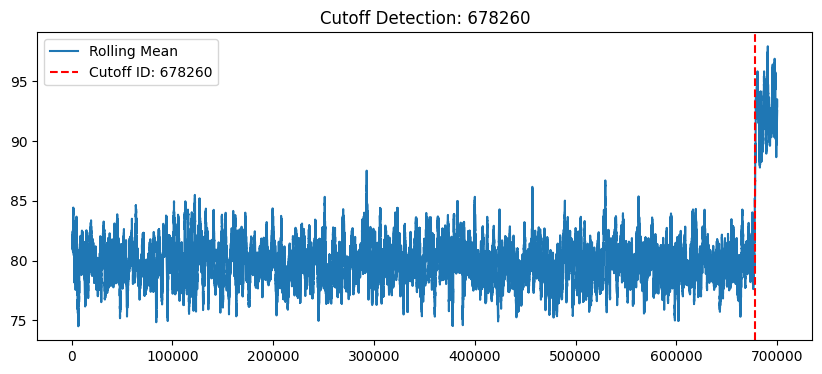


Starting Adversarial Validation...
Training Adversarial Model on 24 features...

Adversarial Validation AUC: 0.4987


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')

target_col = 'physical_activity_minutes_per_week'
window_size = 1000
rolling_mean = train[target_col].rolling(window=window_size).mean()

# Find the first point that exceeds the threshold.
# The graph shows the mean is around 80 before the shift and over 90 after.
# Setting the threshold to 88 to identify the cutoff ID.
threshold = 88
cutoff_mask = rolling_mean > threshold

# Get the first ID that satisfies the condition
cutoff_id = rolling_mean[cutoff_mask].index.min()

print(f"Cutoff ID: {cutoff_id}")

plt.figure(figsize=(10, 4))
plt.plot(train.index, rolling_mean, label='Rolling Mean', color='tab:blue')

if pd.notna(cutoff_id):
    plt.axvline(cutoff_id, color='red', linestyle='--', label=f'Cutoff ID: {cutoff_id}')

plt.title(f'Cutoff Detection: {cutoff_id}')
plt.legend()
plt.show()

# 5. Adversarial Validation
# Objective: Check if "Post-Cutoff Train" is indistinguishable from "Test".
print("\n" + "="*50)
print("Starting Adversarial Validation...")

if pd.notna(cutoff_id):
    # Prepare datasets: Post-Cutoff Train vs Test
    train_subset = train[train.index >= cutoff_id].copy()
    test_subset = test.copy()

    # Assign labels for discrimination (0: Train, 1: Test)
    train_subset['is_test'] = 0
    test_subset['is_test'] = 1

    # Combine
    adv_data = pd.concat([train_subset, test_subset], ignore_index=True)
    
    # Shuffle
    adv_data = adv_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Define features (Drop ID, real target, and the validation label)
    # Note: 'diagnosed_diabetes' is the competition target, present only in train.
    drop_cols = ['id', 'is_test', 'diagnosed_diabetes']
    features = [c for c in test.columns if c not in drop_cols]
    
    # We include 'physical_activity_minutes_per_week' in features to see if the cutoff fixed the shift.

    X = adv_data[features]
    y = adv_data['is_test']

    # Simple Preprocessing (Label Encoding for categoricals)
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])

    # Model Training (LightGBM)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    print(f"Training Adversarial Model on {len(features)} features...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(random_state=42, verbose=-1)
        model.fit(X_train, y_train)
        
        preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        auc_scores.append(score)

    mean_auc = np.mean(auc_scores)
    print(f"\nAdversarial Validation AUC: {mean_auc:.4f}")

In [4]:
orig = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv')

In [5]:
TARGET = 'diagnosed_diabetes'
BASE = [col for col in train.columns if col not in ['id', TARGET]]
CATS = train.select_dtypes('object').columns.to_list()
NUMS = [col for col in BASE if col not in CATS]
print(f'{len(BASE)} Base Features:{BASE}')

24 Base Features:['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [6]:
ORIG = []
for col in BASE:
    # MEAN
    mean_map = orig.groupby(col)[TARGET].mean()
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)

    # COUNT
    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)

print(len(ORIG), 'Orig Features Created!!')

48 Orig Features Created!!


In [7]:
# from itertools import combinations

# INTER = []

# for c1, c2 in combinations(BASE, 2):
#     nc = f'{c1}_{c2}'
#     INTER.append(nc)
#     for df in [train, test]:
#         df[nc] = df[c1].astype(str) + '_' + df[c2].astype(str)

In [8]:
FEATURES = BASE + ORIG

In [9]:
cutoff_id = 678260  
train_df = train[train['id'] < cutoff_id].copy()
val_df = train[train['id'] >= cutoff_id].copy()

In [10]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]
X_val = val_df[FEATURES]
y_val = val_df[TARGET]

In [11]:
# from cuml.preprocessing import TargetEncoder
# from tqdm.auto import tqdm

# for col in INTER:
#     TE = TargetEncoder(smooth=10, n_folds=5, split_method='random')
#     X_train[col] = TE.fit_transform(X_train[col], y_train)
#     X_val[col] = TE.transform(X_val[col])
#     test[col] = TE.transform(test[col])

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

for col in CATS:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    test[col] = test[col].astype('category')

# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.5,
    enable_categorical=True,
    eval_metric='auc',
    early_stopping_rounds=200,
    random_state=42,
    device='cuda',
    n_jobs=-1
)

# Train the model
print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=200,
)

# Predict and Evaluate
y_pred_val = xgb_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_pred_val)

print(f"Validation AUC: {val_auc:.5f}")

Training XGBoost...
[0]	validation_0-auc:0.66033
[200]	validation_0-auc:0.69459
[400]	validation_0-auc:0.69835
[600]	validation_0-auc:0.69933
[800]	validation_0-auc:0.69980
[1000]	validation_0-auc:0.70004
[1200]	validation_0-auc:0.70011
[1400]	validation_0-auc:0.70019
[1542]	validation_0-auc:0.70014
Validation AUC: 0.70022


In [13]:
from tqdm import tqdm 

VAL_WEIGHT_RATIO = 5.0

weights_train = np.ones(len(X_train))
weights_val = np.ones(len(X_val)) * VAL_WEIGHT_RATIO
sample_weights_full = np.concatenate([weights_train, weights_val])

X_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# --- 10 Seeds Training ---

SEEDS = range(42, 52) 
test_preds_sum = np.zeros(len(test))

print(f"Starting 10-seed training on shape {X_full.shape}...")

for i, seed in enumerate(SEEDS):
    print(f"Training Seed {seed} ({i+1}/{len(SEEDS)})...")
    
    xgb_refit = XGBClassifier(
        n_estimators=1700,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        enable_categorical=True,
        eval_metric='auc',
        early_stopping_rounds=None, 
        random_state=seed,          
        device='cuda',
        n_jobs=-1
    )

    xgb_refit.fit(
        X_full, y_full,
        sample_weight=sample_weights_full,
        verbose=False 
    )
    test_preds_sum += xgb_refit.predict_proba(test[FEATURES])[:, 1]

y_pred_test_avg = test_preds_sum / len(SEEDS)

print("Training finished.")

Starting 10-seed training on shape (700000, 72)...
Training Seed 42 (1/10)...
Training Seed 43 (2/10)...
Training Seed 44 (3/10)...
Training Seed 45 (4/10)...
Training Seed 46 (5/10)...
Training Seed 47 (6/10)...
Training Seed 48 (7/10)...
Training Seed 49 (8/10)...
Training Seed 50 (9/10)...
Training Seed 51 (10/10)...
Training finished.


In [14]:
test_preds = xgb_model.predict_proba(test[FEATURES])[:,1]
pd.DataFrame({'id': test.id, TARGET: y_pred_test_avg}).to_csv('submission.csv', index=False)

In [15]:
# BASE : 0.69583
# +ORIG: 0.70036